In [181]:
import laspy
import numpy as np
from sklearn import linear_model, decomposition
import open3d as o3d
import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import math

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
def read_las_file(las_path):
    # Read the LAS file
    las_data = laspy.read(las_path)

    # Extract the points and classifications from the LAS file
    points = np.vstack((las_data.x, las_data.y, las_data.z)).transpose()

    # Create an Open3D PointCloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    #return as point cloud
    return pcd


In [3]:
pcd = read_las_file("finalprojectdata.laz")

In [4]:
number_of_pts = len(pcd.points)
number_of_pts
#o3d.visualization.draw_geometries([pcd])

23299316

In [5]:
pcd_ref, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=0.2)
number_of_pts2 = len(pcd_ref.points)
print(f'Reduced the cloud size by: {round(number_of_pts/(number_of_pts + number_of_pts2)*100)}%')

Reduced the cloud size by: 57%


In [93]:
# voxelize the cloud 
print('voxelization')
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd_ref, voxel_size=1.0)


voxelization


In [142]:
o3d.visualization.draw_geometries([voxel_grid])

In [8]:
points = np.asarray(pcd_ref.points)
voxel_size = voxel_grid.voxel_size

# Use defaultdict to store points temporarily
temp_voxel_points = defaultdict(list)

# Find the points inside each voxel
for point in points:
    voxel_index = tuple((np.floor(point / voxel_size)).astype(int))
    temp_voxel_points[voxel_index].append(point)

# Create final dictionary with only voxels having at least 10 points
voxel_points = {voxel_index: pts for voxel_index, pts in temp_voxel_points.items() if len(pts) >= 10}




In [9]:
num_of_voxels = len(voxel_points)
print(f'number of voxels: {num_of_voxels}')

pca = decomposition.PCA(n_components=3)
#create array to store values for all voxels
all_features = np.ones((num_of_voxels, 10 + 1)) # plus 1 to store voxel index

#test
print(len(list(voxel_points.keys())))

number of voxels: 522645
522645


In [10]:
def std_plane(points, voxel_size):
    # https://gist.github.com/amroamroamro/1db8d69b4b65e8bc66a6

    # The centroid
    centroid = np.sum(points, axis=0)/points.shape[0]

    # Centered data
    c_data = points - centroid
    A = np.c_[c_data[:,0], c_data[:,1], np.ones(c_data.shape[0])]

    # Plane coefficients
    C,_,_,_ = np.linalg.lstsq(A, c_data[:,2], rcond=None)
    #       Z = C[0]*X + C[1]*Y + C[2]
    # =>    C[0]*X + C[1]*Y -1*Z + C[2] = 0

    # Distances from the plane
    distances = np.abs(C[0]*c_data[:,0] + C[1]*c_data[:,1] -1*c_data[:,2] + C[2]) / np.sqrt(C[0]**2 + C[1]**2 + 1)

    # Normalize distances
    distances /= voxel_size

    # Return the standard deviation
    return np.std(distances)



In [11]:
feature_dict = {}
#calculate PCA values for all voxels
for index, (key, values) in enumerate(voxel_points.items()):
    # Stack the arrays into a single 2D array
    all_points = np.stack(values)
    # Extract the z-values
    z_values = all_points[:, 2]
    
    pca.fit(all_points)
    explained_variance = pca.explained_variance_
    l1, l2, l3 = pca.explained_variance_
    #print(l1, l2, l3)

    sum_ev = explained_variance[0] + explained_variance[1] + explained_variance[2]
    L = (l1 - l2) / l1
    P = (l2 - l3) / l1
    S = l3 / l1
    O = (l1 * l2 * l3) ** (1 / 3)
    A = (l1 - l3) / l1
    E = -1 * ((l1 * np.log(l1)) + (l2 * np.log(l2)) + (l3 * np.log(l3)))
    change_curvature = l3 / l1+l2+l3
    z_range = np.max(z_values) - np.min(z_values)
    z_range = z_range / voxel_size
    plane_std = std_plane(points=all_points, voxel_size=1)

    feature_list = [L,P,S,O,A,E,change_curvature, z_range, plane_std, sum_ev]
    feature_dict[key] = feature_list

/var/folders/5v/vnc_js6s26b4ryj6hnqj89bm0000gn/T/ipykernel_2349/761633295.py:20: RuntimeWarning: divide by zero encountered in log
  E = -1 * ((l1 * np.log(l1)) + (l2 * np.log(l2)) + (l3 * np.log(l3)))
/var/folders/5v/vnc_js6s26b4ryj6hnqj89bm0000gn/T/ipykernel_2349/761633295.py:20: RuntimeWarning: invalid value encountered in scalar multiply
  E = -1 * ((l1 * np.log(l1)) + (l2 * np.log(l2)) + (l3 * np.log(l3)))
/var/folders/5v/vnc_js6s26b4ryj6hnqj89bm0000gn/T/ipykernel_2349/761633295.py:20: RuntimeWarning: divide by zero encountered in log
  E = -1 * ((l1 * np.log(l1)) + (l2 * np.log(l2)) + (l3 * np.log(l3)))
/var/folders/5v/vnc_js6s26b4ryj6hnqj89bm0000gn/T/ipykernel_2349/761633295.py:20: RuntimeWarning: invalid value encountered in scalar multiply
  E = -1 * ((l1 * np.log(l1)) + (l2 * np.log(l2)) + (l3 * np.log(l3)))


In [12]:
feature_dict

{(569749, 7033800, 9): [0.7991459407570122,
  0.1990034793765355,
  0.0018505798664523205,
  0.006213496614034345,
  0.9981494201335477,
  0.2833607801641344,
  0.019368005080367057,
  0.08999999999999986,
  0.004281409630166471,
  0.10393589738542279],
 (569750, 7033800, 8): [0.18798014767385637,
  0.8078264400029933,
  0.004193412323150415,
  0.012367795467185555,
  0.9958065876768496,
  0.38883213781714837,
  0.07129269409149863,
  0.129999999999999,
  0.010162332182952689,
  0.1493073083644108],
 (569751, 7033800, 8): [0.16950003698397018,
  0.8286169639994468,
  0.0018829990165830546,
  0.009828206317807639,
  0.9981170009834169,
  0.39712787187181076,
  0.07236326645489681,
  0.08000000000000007,
  0.006418082687371117,
  0.15515315318096107],
 (569752, 7033800, 8): [0.3658202263345217,
  0.6327991504353153,
  0.0013806232301629784,
  0.010893841322256254,
  0.998619376769837,
  0.4385745330823101,
  0.07375341930941241,
  0.129999999999999,
  0.0063250583102866164,
  0.186245209

In [14]:
df = pd.DataFrame.from_dict(feature_dict, orient='index', columns=['linearity','planarity','scattering', 'omnivariance', 'anistropy', 'eigenentropy', 'change_curvature', 'z_range', 'plane_std', 'sum_ev'])
#features_and_point_df = df[(af[0] != 1) & (af[1] != 1) & (af[2] != 1) & (af[3] != 1)]
#features_and_point_df
df


,linearity,planarity,scattering,omnivariance,anistropy,eigenentropy,change_curvature,z_range,plane_std,sum_ev
"(569749, 7033800, 9)",0.79915,0.19900,0.00185,0.00621,0.99815,0.28336,0.01937,0.09000,0.00428,0.10394
"(569750, 7033800, 8)",0.18798,0.80783,0.00419,0.01237,0.99581,0.38883,0.07129,0.13000,0.01016,0.14931
"(569751, 7033800, 8)",0.16950,0.82862,0.00188,0.00983,0.99812,0.39713,0.07236,0.08000,0.00642,0.15515
"(569752, 7033800, 8)",0.36582,0.63280,0.00138,0.01089,0.99862,0.43857,0.07375,0.13000,0.00633,0.18625
"(569753, 7033800, 8)",0.34611,0.65268,0.00121,0.01061,0.99879,0.44412,0.07642,0.11000,0.00717,0.19002
...,...,...,...,...,...,...,...,...,...,...
"(570240, 7034353, 12)",0.57035,0.40187,0.02778,0.02306,0.97222,0.38399,0.07394,0.46000,0.03321,0.14708
"(570239, 7034352, 12)",0.47688,0.45797,0.06515,0.03742,0.93485,0.45549,0.13306,0.65000,0.04997,0.18333
"(570238, 7034351, 12)",0.50010,0.47551,0.02439,0.02047,0.97561,0.36689,0.07102,0.30000,0.03493,0.13554
"(570223, 7034319, 37)",0.78426,0.20431,0.01142,0.01503,0.98858,0.34229,0.03669,0.57000,0.01920,0.13652


array([[<Axes: title={'center': 'linearity'}>,
        <Axes: title={'center': 'planarity'}>,
        <Axes: title={'center': 'scattering'}>],
       [<Axes: title={'center': 'omnivariance'}>,
        <Axes: title={'center': 'anistropy'}>,
        <Axes: title={'center': 'eigenentropy'}>],
       [<Axes: title={'center': 'change_curvature'}>,
        <Axes: title={'center': 'z_range'}>,
        <Axes: title={'center': 'plane_std'}>],
       [<Axes: title={'center': 'sum_ev'}>, <Axes: >, <Axes: >]],
      dtype=object)

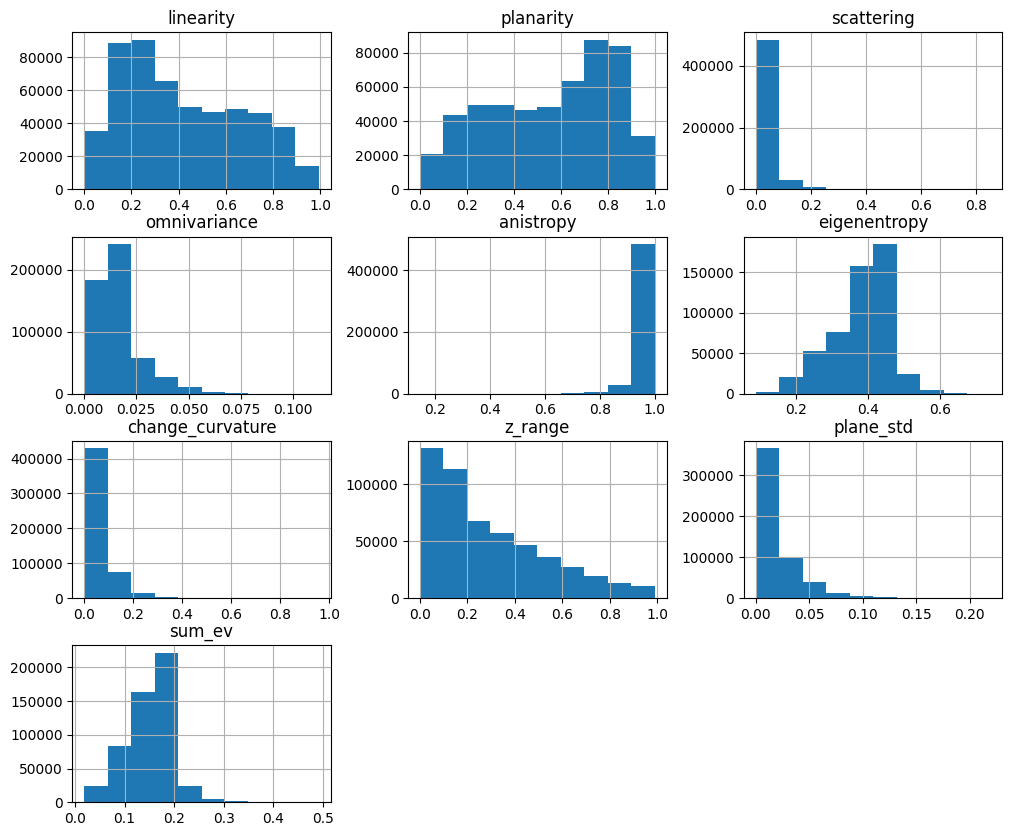

In [15]:
df.hist(figsize=(12,10))

In [45]:
tree_areas= [((570331, 7034100), (570373, 7034125)), ((569779, 7033836),(569851, 7033922))]
building_areas = [((569738,7034147),(569767, 7034185)),((569739,7034199),(569764, 7034231))]
terrain_areas = [((570382, 7034021),(570426, 7034045)), ((570314, 7033759),(570379, 7033787))]
    

In [60]:
def find_voxels_in_df(df, min_east, min_north, max_east, max_north):
    """
    Find all voxels within the specified 2D coordinates based on a DataFrame.

    :param df: DataFrame where indices are 2D voxel coordinates (e.g., (x, y)).
    :param min_east, min_north, max_east, max_north: The bounding box coordinates.
    :return: A list of voxel indices that fall within the specified coordinates.
    """
    selected_voxels = []

    # Iterate through the DataFrame indices
    for index in df.index:
        # Check if the index (voxel coordinate) falls within the specified 2D coordinate range
        if min_east <= index[0] <= max_east and min_north <= index[1] <= max_north:
            selected_voxels.append(index)

    return selected_voxels
    

In [129]:
voxels_in_range_trees = find_voxels_in_df(df, 570331, 7034100, 570373, 7034125)
voxels_in_range_trees2 = find_voxels_in_df(df, 569779, 7033836,569851, 7033922)
len(voxels_in_range_trees2)

5667

In [128]:
voxels_in_range_buildings = find_voxels_in_df(df,569738,7034147,569767, 7034185)
voxels_in_range_buildings2 = find_voxels_in_df(df,569739,7034199,569764, 7034231)
len(voxels_in_range_buildings2)

1183

In [143]:
voxels_in_range_terrain = find_voxels_in_df(df,570382, 7034021,570426, 7034045)
voxels_in_range_terrain2 = find_voxels_in_df(df,570312, 7033878,570341, 7033907)

len(voxels_in_range_terrain2)

1001

In [71]:
def extract_points_from_dict(dict, voxel_indices):
    interest_cloud = o3d.geometry.PointCloud()
    for index in voxel_indices:
        points = dict[index]
        tmp_cloud = o3d.geometry.PointCloud()
        tmp_cloud.points = o3d.utility.Vector3dVector(np.stack(points))
        interest_cloud += tmp_cloud
    return interest_cloud

def extract_points_from_df(df, voxel_indices):
    # Filter the DataFrame
    filtered_df = df.loc[voxel_indices]
    return filtered_df

def filter_df_by_z_threshold(df, z_threshold):

    # Find the lowest z-value in the DataFrame index
    min_z = min(idx[2] for idx in df.index)

    # Filter out points within the z-value threshold of the lowest point
    filtered_df = df[[idx[2] > min_z + z_threshold for idx in df.index]]

    return filtered_df

In [131]:
tree_cloud = extract_points_from_dict(voxel_points, voxels_in_range_trees2 )
# Visualize
o3d.visualization.draw_geometries([tree_cloud]) 

In [135]:
#small cleaning to not include terrain pts
tree_df = extract_points_from_df(df, voxels_in_range_trees)
tree_df2 = extract_points_from_df(df, voxels_in_range_trees2)
tree_df_filtered = filter_df_by_z_threshold(tree_df, z_threshold=10)
tree_df_filtered2 = filter_df_by_z_threshold(tree_df2, z_threshold=7)
tree_df_filtered2


,linearity,planarity,scattering,omnivariance,anistropy,eigenentropy,change_curvature,z_range,plane_std,sum_ev
"(569788, 7033847, 20)",0.88118,0.10152,0.01730,0.01407,0.98270,0.31258,0.03237,0.42000,0.02353,0.12576
"(569787, 7033846, 18)",0.89364,0.07209,0.03427,0.01785,0.96573,0.32605,0.05058,0.55000,0.02864,0.13229
"(569785, 7033837, 19)",0.56683,0.36016,0.07301,0.01146,0.92699,0.20113,0.09135,0.26000,0.02952,0.05458
"(569784, 7033836, 15)",0.60731,0.32042,0.07228,0.01667,0.92772,0.26314,0.09769,0.19000,0.02998,0.08005
"(569786, 7033842, 20)",0.80652,0.14543,0.04805,0.01286,0.95195,0.24058,0.06282,0.19000,0.02432,0.07596
...,...,...,...,...,...,...,...,...,...,...
"(569836, 7033902, 24)",0.90615,0.07430,0.01955,0.00912,0.98045,0.23772,0.02800,0.17000,0.02490,0.08297
"(569839, 7033913, 25)",0.68110,0.25163,0.06727,0.00941,0.93273,0.17737,0.08035,0.16000,0.02563,0.04693
"(569838, 7033912, 25)",0.75134,0.22656,0.02210,0.01223,0.97790,0.26485,0.04086,0.41000,0.02167,0.08804
"(569837, 7033909, 24)",0.76267,0.22948,0.00785,0.00802,0.99215,0.24627,0.02382,0.10000,0.01130,0.08112


In [136]:
tree_cloud = extract_points_from_dict(voxel_points, tree_df_filtered2.index)
# Visualize
o3d.visualization.draw_geometries([tree_cloud]) 

In [137]:
building_df = extract_points_from_df(df, voxels_in_range_buildings + voxels_in_range_buildings2)
building_df_filtered=filter_df_by_z_threshold(building_df, z_threshold=5)
building_df_filtered

,linearity,planarity,scattering,omnivariance,anistropy,eigenentropy,change_curvature,z_range,plane_std,sum_ev
"(569744, 7034152, 19)",0.85048,0.14543,0.00409,0.00658,0.99591,0.25254,0.01600,0.06000,0.01112,0.08948
"(569743, 7034152, 19)",0.75069,0.24564,0.00367,0.00586,0.99633,0.23445,0.01893,0.05000,0.00800,0.07562
"(569743, 7034152, 20)",0.55061,0.44568,0.00371,0.01157,0.99629,0.36719,0.04794,0.15000,0.00896,0.14187
"(569744, 7034152, 20)",0.40540,0.59138,0.00322,0.01004,0.99678,0.35136,0.05155,0.14000,0.00974,0.12916
"(569744, 7034151, 20)",0.34091,0.65631,0.00278,0.01366,0.99722,0.43927,0.07667,0.20000,0.01013,0.18553
...,...,...,...,...,...,...,...,...,...,...
"(569742, 7034199, 20)",0.25619,0.72021,0.02360,0.03060,0.97640,0.48153,0.11397,0.67000,0.03359,0.20812
"(569743, 7034204, 20)",0.62235,0.37556,0.00209,0.00858,0.99791,0.33972,0.03733,0.46000,0.00686,0.12804
"(569743, 7034203, 20)",0.57711,0.41867,0.00422,0.01073,0.99578,0.34048,0.04201,0.38000,0.01065,0.12629
"(569743, 7034202, 20)",0.75982,0.23835,0.00183,0.00680,0.99817,0.29962,0.02345,0.29000,0.00813,0.11095


In [138]:
building_cloud = extract_points_from_dict(voxel_points, building_df_filtered.index)
o3d.visualization.draw_geometries([building_cloud]) 

In [109]:
terrain_cloud = extract_points_from_dict(voxel_points, voxels_in_range_terrain)
# Visualize
o3d.visualization.draw_geometries([terrain_cloud]) 

In [147]:
terrain_df = extract_points_from_df(df, voxels_in_range_terrain +  voxels_in_range_terrain2)
terrain_df

,linearity,planarity,scattering,omnivariance,anistropy,eigenentropy,change_curvature,z_range,plane_std,sum_ev
"(570382, 7034045, 54)",0.41638,0.58228,0.00134,0.01032,0.99866,0.42514,0.06694,0.30000,0.00639,0.17775
"(570382, 7034044, 54)",0.13625,0.86238,0.00137,0.01022,0.99863,0.43443,0.08502,0.25000,0.00723,0.18035
"(570382, 7034043, 54)",0.16666,0.83122,0.00212,0.01111,0.99788,0.41805,0.07897,0.24000,0.00859,0.16884
"(570383, 7034045, 54)",0.36477,0.63462,0.00061,0.00820,0.99939,0.43503,0.07215,0.28000,0.00532,0.18405
"(570382, 7034042, 54)",0.17545,0.82277,0.00177,0.00969,0.99823,0.39825,0.07233,0.22000,0.00700,0.15594
...,...,...,...,...,...,...,...,...,...,...
"(570312, 7033907, 37)",0.59751,0.40108,0.00141,0.00937,0.99859,0.38881,0.04714,0.05000,0.00760,0.15897
"(570321, 7033902, 53)",0.95130,0.01818,0.03051,0.02735,0.96949,0.43028,0.04950,0.79000,0.05096,0.25865
"(570324, 7033905, 53)",0.75258,0.20145,0.04597,0.01698,0.95403,0.28908,0.06813,0.22000,0.03257,0.09766
"(570327, 7033906, 53)",0.81618,0.11447,0.06935,0.01599,0.93065,0.26402,0.08668,0.33000,0.04622,0.08578


array([[<Axes: title={'center': 'linearity'}>,
        <Axes: title={'center': 'planarity'}>,
        <Axes: title={'center': 'scattering'}>],
       [<Axes: title={'center': 'omnivariance'}>,
        <Axes: title={'center': 'anistropy'}>,
        <Axes: title={'center': 'eigenentropy'}>],
       [<Axes: title={'center': 'change_curvature'}>,
        <Axes: title={'center': 'z_range'}>,
        <Axes: title={'center': 'plane_std'}>],
       [<Axes: title={'center': 'sum_ev'}>, <Axes: >, <Axes: >]],
      dtype=object)

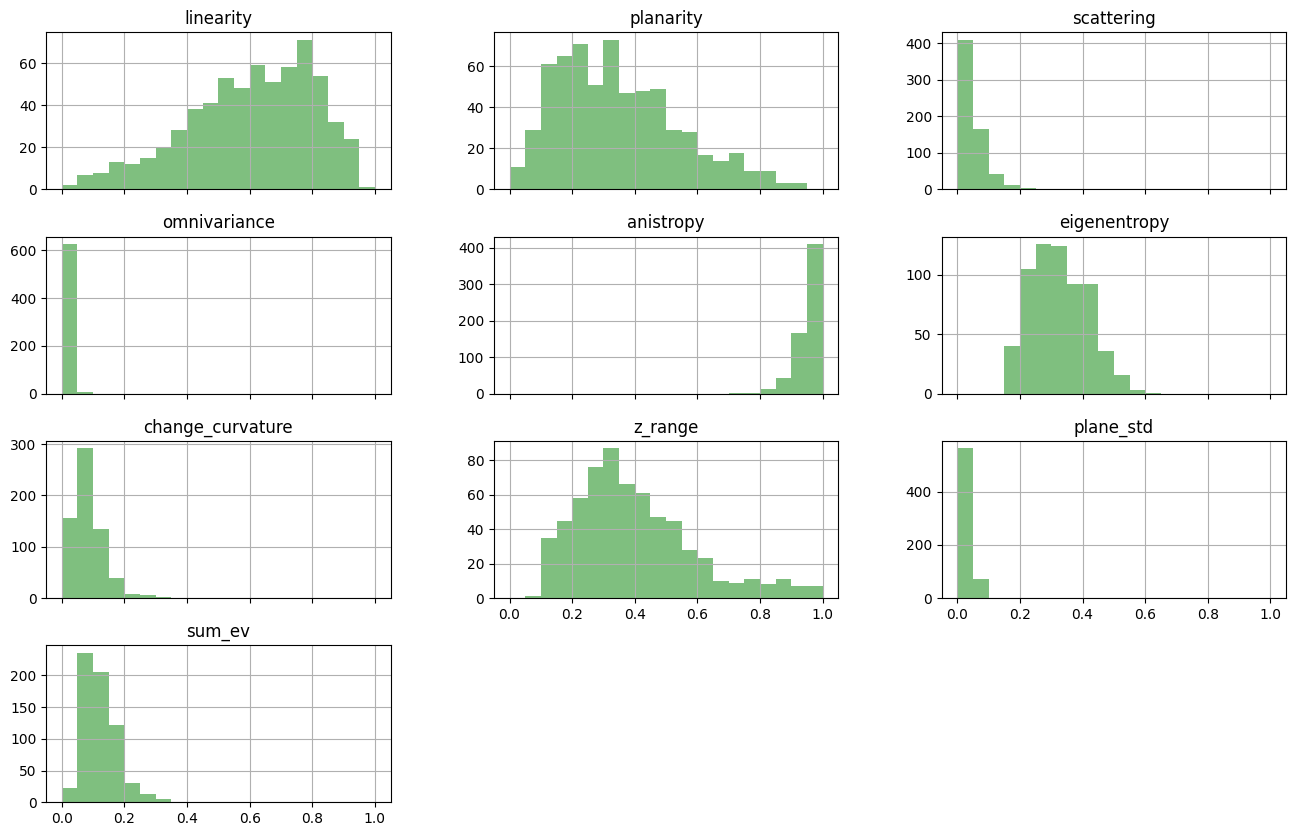

In [124]:
bin_range = [0, 1]
num_bins = 20 
tree_df_filtered.hist(color='green', bins=num_bins, range=bin_range, figsize=(16,10), sharex=True, alpha=0.5)

array([[<Axes: title={'center': 'linearity'}>,
        <Axes: title={'center': 'planarity'}>,
        <Axes: title={'center': 'scattering'}>],
       [<Axes: title={'center': 'omnivariance'}>,
        <Axes: title={'center': 'anistropy'}>,
        <Axes: title={'center': 'eigenentropy'}>],
       [<Axes: title={'center': 'change_curvature'}>,
        <Axes: title={'center': 'z_range'}>,
        <Axes: title={'center': 'plane_std'}>],
       [<Axes: title={'center': 'sum_ev'}>, <Axes: >, <Axes: >]],
      dtype=object)

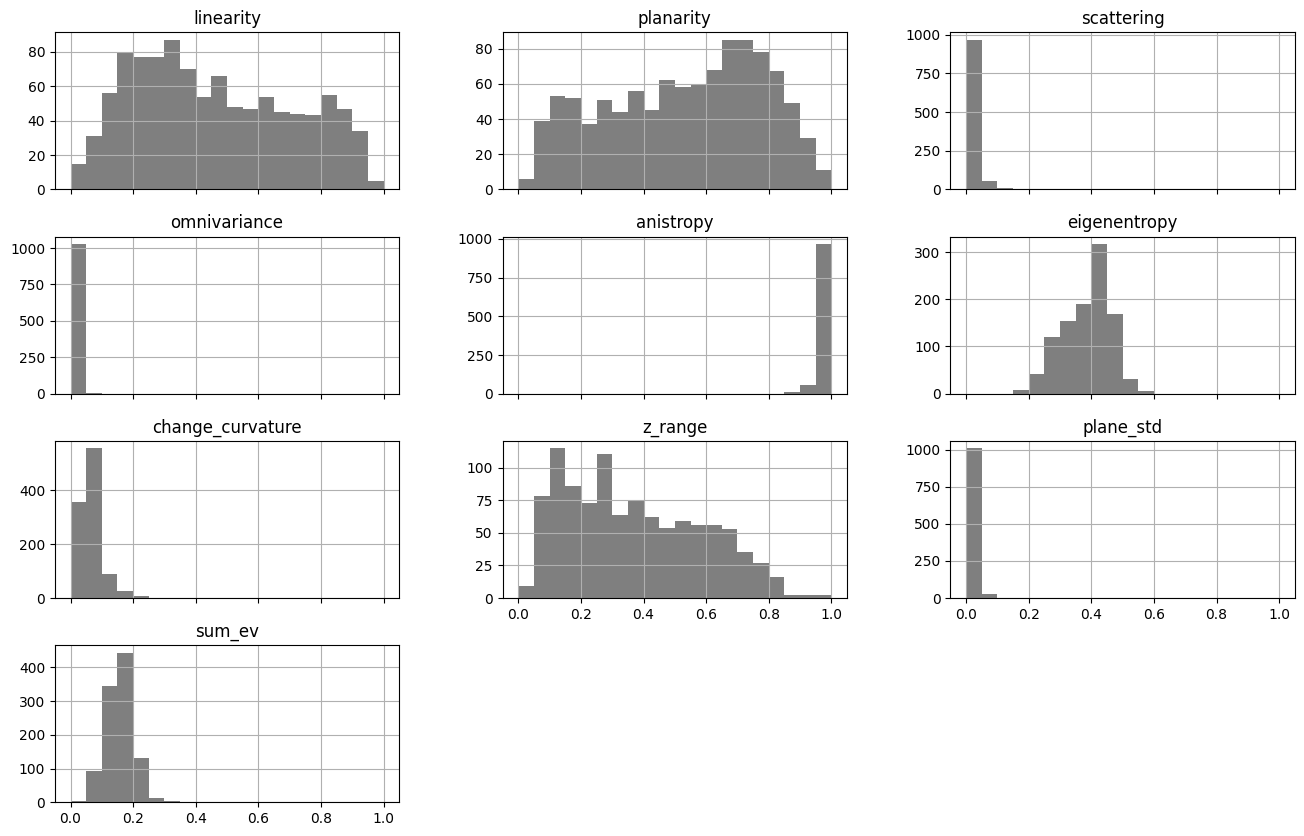

In [125]:
building_df_filtered.hist(color='black', bins=num_bins, range=bin_range, figsize=(16,10), sharex=True, alpha=0.5)

array([[<Axes: title={'center': 'linearity'}>,
        <Axes: title={'center': 'planarity'}>,
        <Axes: title={'center': 'scattering'}>],
       [<Axes: title={'center': 'omnivariance'}>,
        <Axes: title={'center': 'anistropy'}>,
        <Axes: title={'center': 'eigenentropy'}>],
       [<Axes: title={'center': 'change_curvature'}>,
        <Axes: title={'center': 'z_range'}>,
        <Axes: title={'center': 'plane_std'}>],
       [<Axes: title={'center': 'sum_ev'}>, <Axes: >, <Axes: >]],
      dtype=object)

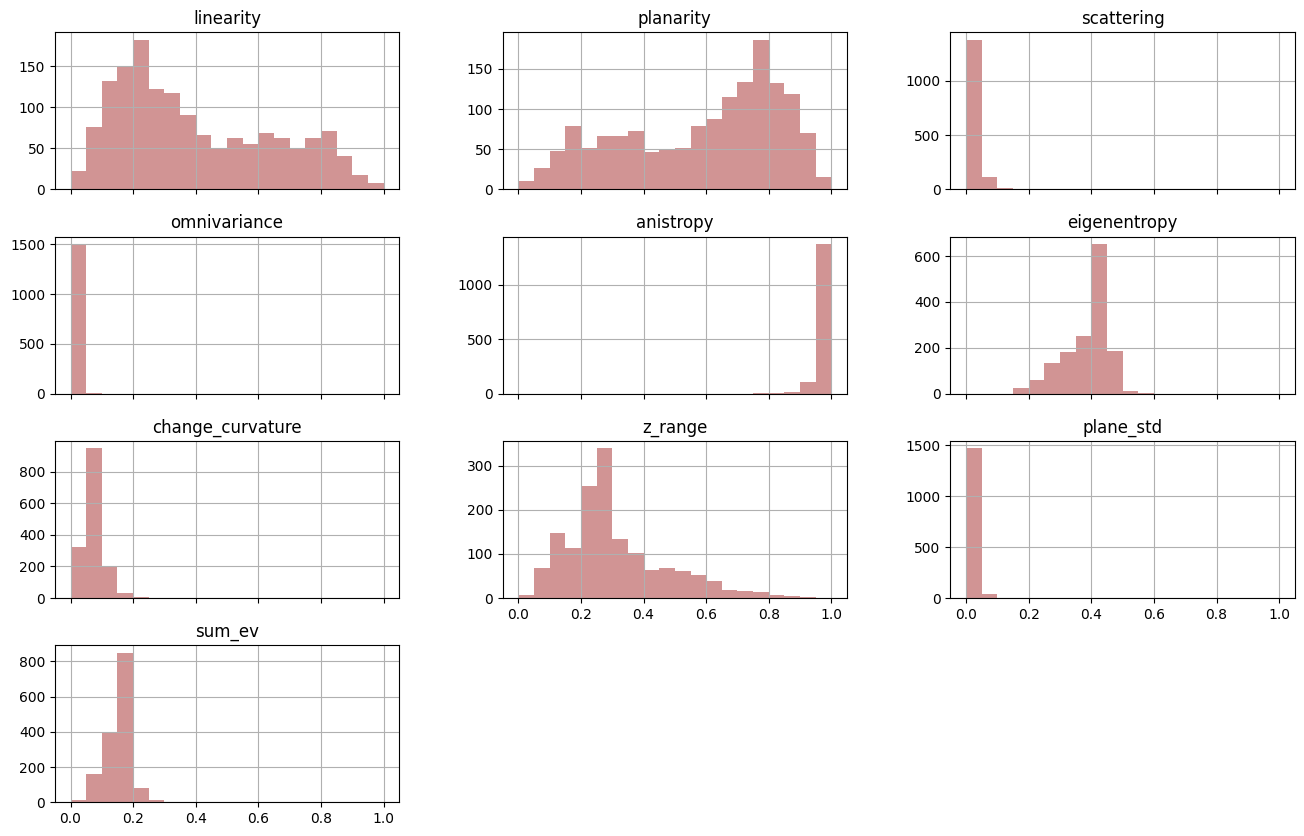

In [148]:
terrain_df.hist(color='brown', bins=num_bins, range=bin_range, figsize=(16,10), sharex=True, alpha=0.5)

In [152]:
# Calculate averages
avg_trees = tree_df_filtered.mean()
avg_buildings = building_df_filtered.mean()
avg_terrain = terrain_df.mean()

# Display the averages
print("Average for Trees:\n", average_trees)
print()
print("Average for Buildings:\n", average_buildings)
print()
print("Average for Terrain:\n", average_terrain)
print()

Average for Trees:
 linearity          0.60370
planarity          0.34731
scattering         0.04898
omnivariance       0.02028
anistropy          0.95102
eigenentropy       0.32568
change_curvature   0.08393
z_range            0.39570
plane_std          0.03287
sum_ev             0.12162
dtype: float64

Average for Buildings:
 linearity          0.47494
planarity          0.51108
scattering         0.01398
omnivariance       0.01514
anistropy          0.98602
eigenentropy       0.38016
change_curvature   0.06767
z_range            0.40168
plane_std          0.01689
sum_ev             0.15322
dtype: float64

Average for Terrain:
 linearity          0.39840
planarity          0.58533
scattering         0.01627
omnivariance       0.01540
anistropy          0.98373
eigenentropy       0.38600
change_curvature   0.07481
z_range            0.30840
plane_std          0.01741
sum_ev             0.15339
dtype: float64



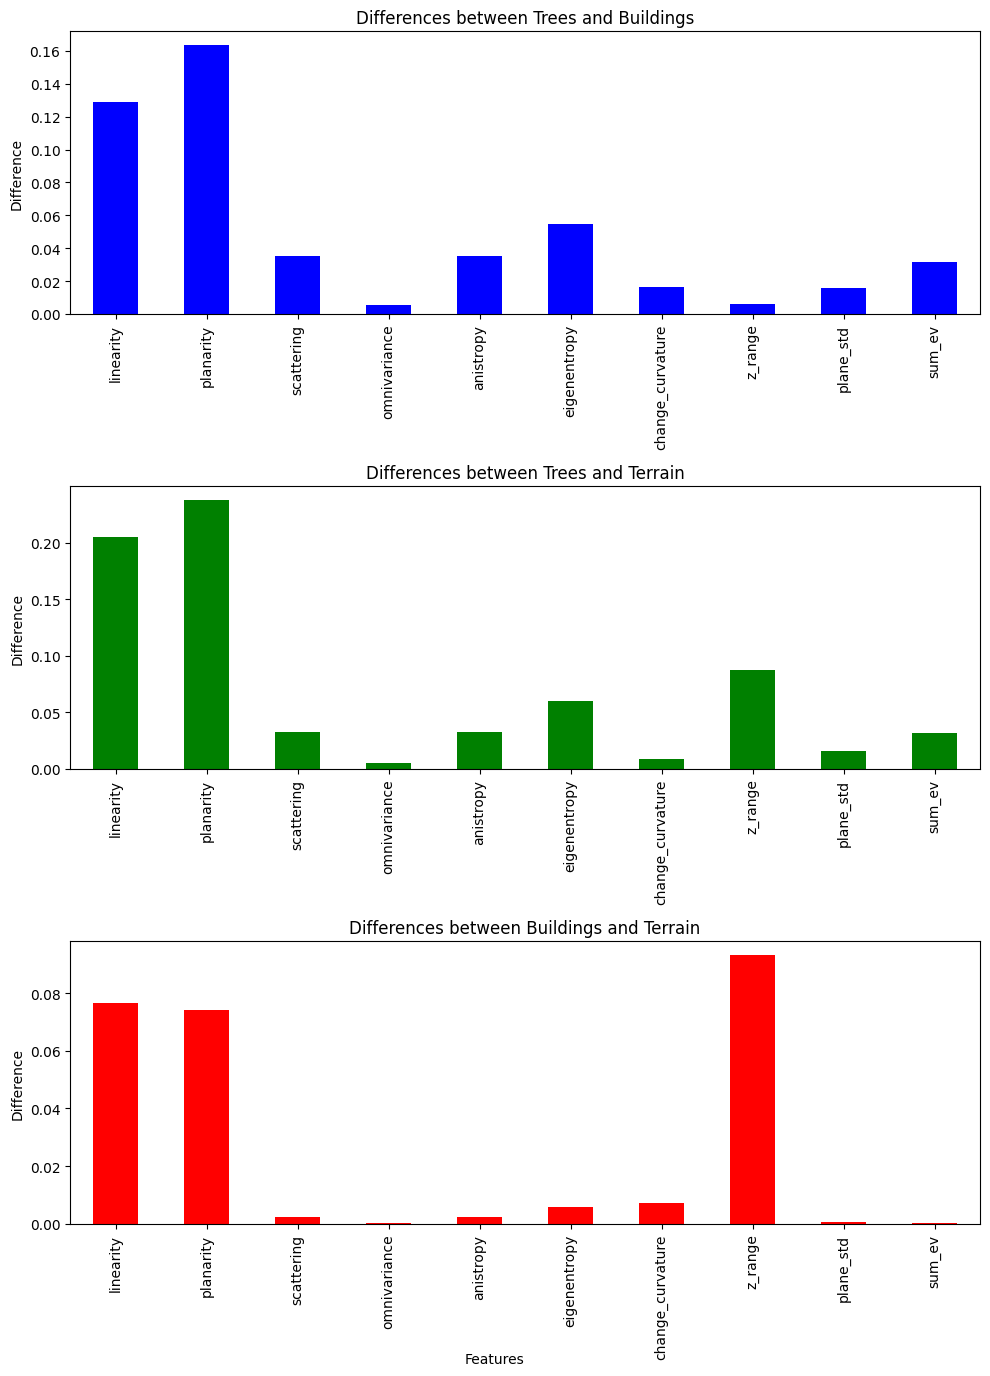

Differences between Trees and Buildings:
 linearity          0.12877
planarity          0.16376
scattering         0.03500
omnivariance       0.00514
anistropy          0.03500
eigenentropy       0.05448
change_curvature   0.01626
z_range            0.00597
plane_std          0.01598
sum_ev             0.03160
dtype: float64
Differences between Trees and Terrain:
 linearity          0.20531
planarity          0.23802
scattering         0.03271
omnivariance       0.00488
anistropy          0.03271
eigenentropy       0.06032
change_curvature   0.00911
z_range            0.08730
plane_std          0.01546
sum_ev             0.03177
dtype: float64
Differences between Buildings and Terrain:
 linearity          0.07654
planarity          0.07426
scattering         0.00229
omnivariance       0.00027
anistropy          0.00229
eigenentropy       0.00584
change_curvature   0.00714
z_range            0.09327
plane_std          0.00052
sum_ev             0.00017
dtype: float64


In [158]:
# Calculate differences between categories for each feature
diff_trees_buildings = abs(avg_trees - avg_buildings)
diff_trees_terrain = abs(avg_trees - avg_terrain)
diff_buildings_terrain = abs(avg_buildings - avg_terrain)

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Plot each Series on its own subplot
diff_trees_buildings.plot(kind='bar', ax=axes[0], color='blue', title='Differences between Trees and Buildings')
diff_trees_terrain.plot(kind='bar', ax=axes[1], color='green', title='Differences between Trees and Terrain')
diff_buildings_terrain.plot(kind='bar', ax=axes[2], color='red', title='Differences between Buildings and Terrain')

# Set labels for x and y axis
axes[0].set_ylabel('Difference')
axes[1].set_ylabel('Difference')
axes[2].set_ylabel('Difference')

# Set a common x label
fig.text(0.5, 0.04, 'Features', ha='center', va='center')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()
# Identify features with the largest differences
# You might want to consider a threshold or just look for the top few features with the largest differences
print("Differences between Trees and Buildings:\n", diff_trees_buildings)
print("Differences between Trees and Terrain:\n", diff_trees_terrain)
print("Differences between Buildings and Terrain:\n", diff_buildings_terrain)

In [185]:
def find_closest_category(values, avg_trees, avg_buildings, avg_terrain):
    """
    Find the category (trees, buildings, or terrain) that the given value is closest to
    based on average values of planarity and linearity.

    :param value: A tuple (planarity, linearity) representing the value to compare.
    :param avg_trees: A tuple representing the average (planarity, linearity) for trees.
    :param avg_buildings: A tuple representing the average (planarity, linearity) for buildings.
    :param avg_terrain: A tuple representing the average (planarity, linearity) for terrain.
    :return: The category ('Trees', 'Buildings', or 'Terrain') closest to the given value.
    """
    # Euclidean distance function
    def euclidean_distance(v1, v2):
        return math.sqrt((v1[0] - v2[0]) ** 2 + (v1[1] - v2[1]) ** 2)

    # Calculate distances to each category
    distance_to_trees = euclidean_distance(values, avg_trees)
    distance_to_buildings = euclidean_distance(values, avg_buildings)
    distance_to_terrain = euclidean_distance(values, avg_terrain)

    # Find the minimum distance and corresponding category
    min_distance = min(distance_to_trees, distance_to_buildings, distance_to_terrain)
    if min_distance == distance_to_trees:
        return 'Tree'
    elif min_distance == distance_to_buildings:
        return 'Building'
    else:
        return 'Terrain'

In [234]:
# we use Z-range, planearity, linearity to classify the point cloud
avgs_trees = (average_trees.iloc[0], average_trees.iloc[1])
#trees_zrange =  average_trees.iloc[7]

avgs_buildings = (average_buildings.iloc[0], average_buildings.iloc[1])
#buildings_zrange =  average_buildings.iloc[7]

avgs_terrain = (average_terrain.iloc[0], average_terrain.iloc[1])
#terrain_zrange =  average_terrain.iloc[7]

def classify_rows(df, avgs_trees, avgs_buildings, avgs_terrain):
    # Create a copy of the DataFrame to add the classifications
    classified_df = df.copy()
    # Initialize a new column with a default string value
    classified_df['classification'] = 'unclassified'

    # Iterate through each row in the DataFrame
    for index, row in classified_df.iterrows():
        # Extract the relevant values from the row
        values = (row['linearity'], row['planarity'])

        # Find the closest category using the helper function
        classification = find_closest_category(values, avgs_trees, avgs_buildings, avgs_terrain)

        # Assign the classification to a new column for this row
        classified_df.at[index, 'classification'] = classification

    return classified_df


        
        
    



In [236]:
classified_df = classify_rows(df, avgs_trees, avgs_buildings, avgs_terrain)
classified_df

,linearity,planarity,scattering,omnivariance,anistropy,eigenentropy,change_curvature,z_range,plane_std,sum_ev,classification
"(569749, 7033800, 9)",0.79915,0.19900,0.00185,0.00621,0.99815,0.28336,0.01937,0.09000,0.00428,0.10394,Tree
"(569750, 7033800, 8)",0.18798,0.80783,0.00419,0.01237,0.99581,0.38883,0.07129,0.13000,0.01016,0.14931,Terrain
"(569751, 7033800, 8)",0.16950,0.82862,0.00188,0.00983,0.99812,0.39713,0.07236,0.08000,0.00642,0.15515,Terrain
"(569752, 7033800, 8)",0.36582,0.63280,0.00138,0.01089,0.99862,0.43857,0.07375,0.13000,0.00633,0.18625,Terrain
"(569753, 7033800, 8)",0.34611,0.65268,0.00121,0.01061,0.99879,0.44412,0.07642,0.11000,0.00717,0.19002,Terrain
...,...,...,...,...,...,...,...,...,...,...,...
"(570240, 7034353, 12)",0.57035,0.40187,0.02778,0.02306,0.97222,0.38399,0.07394,0.46000,0.03321,0.14708,Tree
"(570239, 7034352, 12)",0.47688,0.45797,0.06515,0.03742,0.93485,0.45549,0.13306,0.65000,0.04997,0.18333,Building
"(570238, 7034351, 12)",0.50010,0.47551,0.02439,0.02047,0.97561,0.36689,0.07102,0.30000,0.03493,0.13554,Building
"(570223, 7034319, 37)",0.78426,0.20431,0.01142,0.01503,0.98858,0.34229,0.03669,0.57000,0.01920,0.13652,Tree


In [241]:
# we use classification to paint each voxel in the pointc_cloud
complete_cloud = o3d.geometry.PointCloud()
for index, row in classified_df.iterrows():
    if row['classification'] == 'Tree':
        tmp_cloud = o3d.geometry.PointCloud()
        points = np.stack(voxel_points[index])
        tmp_cloud.points = o3d.utility.Vector3dVector(points)
        tmp_cloud.paint_uniform_color([0,1,0])
        complete_cloud += tmp_cloud
    if row['classification'] == 'Building':
        tmp_cloud = o3d.geometry.PointCloud()
        points = np.stack(voxel_points[index])
        tmp_cloud.points = o3d.utility.Vector3dVector(points)
        tmp_cloud.paint_uniform_color([0,0,1])
        complete_cloud += tmp_cloud
    if row['classification'] == 'Terrain':
        tmp_cloud = o3d.geometry.PointCloud()
        points = np.stack(voxel_points[index])
        tmp_cloud.points = o3d.utility.Vector3dVector(points)
        tmp_cloud.paint_uniform_color([0,0,0])
        complete_cloud += tmp_cloud
        
o3d.visualization.draw_geometries([complete_cloud])   
    

In [16]:
# Access a random row
random_row = df.sample()
print(f'random selected row: {random_row}')
random_voxel_idx = random_row.index[0]

inlier_points = voxel_points[random_voxel_idx]
inlier_points_array = np.stack(inlier_points)

o3dvoxel = o3d.geometry.PointCloud()
o3dvoxel_elevated = o3d.geometry.PointCloud()

o3dvoxel.points = o3d.utility.Vector3dVector(inlier_points_array)
o3dvoxel_elevated.points = o3d.utility.Vector3dVector(inlier_points_array[:,:3]+[0,0,100])

o3dvoxel_elevated.paint_uniform_color([1,0,0])
o3dvoxel.paint_uniform_color([1,0,0])
o3d.visualization.draw_geometries([o3dvoxel, o3dvoxel_elevated, pcd_ref])

random selected row:                        linearity  planarity  scattering  omnivariance  \
(570172, 7033825, 15)    0.11447    0.88244     0.00309       0.01119   

                       anistropy  eigenentropy  change_curvature  z_range  \
(570172, 7033825, 15)    0.99691       0.39153           0.07415  0.13000   

                       plane_std  sum_ev  
(570172, 7033825, 15)    0.00938 0.15101  


In [42]:
# Access a random row
random_row = df.sample()
#print(f'random selected row: {random_row}')
random_voxel_idx = random_row.index[0]

print(random_voxel_idx)
print(np.array((random_voxel_idx[0]- voxel_size/2, random_voxel_idx[1]- voxel_size/2, random_voxel_idx[2]- voxel_size/2) ))


# Assuming voxel_size is known, and random_voxel_idx is the center of the voxel
#voxel_center = np.array(voxel_points[random_voxel_idx][0])
# We calculate the 
voxel_center = np.array((random_voxel_idx[0]- voxel_size/2, random_voxel_idx[1]- voxel_size/2, random_voxel_idx[2]- voxel_size/2) )
half_size = 20  # Half the size of the bounding box

# Create a bounding box
bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=voxel_center - half_size,
                                           max_bound=voxel_center + half_size)

# Extract points within the bounding box from the original point cloud
points_o3d = o3d.utility.Vector3dVector(np.asarray(pcd_ref.points))  # Convert to Vector3dVector
inlier_indices = bbox.get_point_indices_within_bounding_box(points_o3d)
inlier_points_array_bb = np.asarray(pcd_ref.points)[inlier_indices]

# Create a PointCloud for visualization
subchunk = o3d.geometry.PointCloud()
subchunk.points = o3d.utility.Vector3dVector(inlier_points_array_bb)
subchunk.paint_uniform_color([0,0,0])

# visualize the voxel
inlier_points = voxel_points[random_voxel_idx]
inlier_points_array = np.stack(inlier_points)
o3dvoxel = o3d.geometry.PointCloud()
o3dvoxel.points = o3d.utility.Vector3dVector(inlier_points_array)
o3dvoxel.paint_uniform_color([0,1,0])


# Visualize
o3d.visualization.draw_geometries([subchunk, o3dvoxel])  


(569736, 7033994, 29)
[5.6973550e+05 7.0339935e+06 2.8500000e+01]


In [19]:
tree_indices = [(570368, 7034210, 54),(570083, 7034144, 27), (569803, 7033919, 33), (569739, 7034333, 17), (570349, 7034136, 53), (570236, 7034122, 36), (570074, 7033931, 34) ]
building_indices = [ (569776, 7034285, 22), (569911, 7034328, 16), (570227, 7034315, 22), (570031, 7034021, 12), (569820, 7034360, 24), (569600, 7034260, 26) ]
terrain_indices = [ (570261, 7033803, 23), (569638, 7034074, 12), (570134, 7034127, 27), (569772, 7034144, 10), (569663, 7034285, 9), (570171, 7034219, 21), (570241, 7033933, 29), (570127, 7033856, 16), (570095, 7033847, 9)]

In [20]:
# Function to calculate the average for each column based on indices
def calculate_average(df, indices):
    filtered_df = df.loc[indices]
    return filtered_df.mean()

# Calculate averages
average_trees = calculate_average(df, tree_indices)
average_buildings = calculate_average(df, building_indices)
average_terrain = calculate_average(df, terrain_indices)

# Display the averages
print("Average for Trees:\n", average_trees)
print()
print("Average for Buildings:\n", average_buildings)
print()
print("Average for Terrain:\n", average_terrain)
print()

Average for Trees:
 linearity          0.60925
planarity          0.31725
scattering         0.07350
omnivariance       0.02462
anistropy          0.92650
eigenentropy       0.34206
change_curvature   0.11244
z_range            0.43286
plane_std          0.04282
sum_ev             0.12579
dtype: float64

Average for Buildings:
 linearity          0.55365
planarity          0.44213
scattering         0.00421
omnivariance       0.01171
anistropy          0.99579
eigenentropy       0.36581
change_curvature   0.04928
z_range            0.42667
plane_std          0.01210
sum_ev             0.14548
dtype: float64

Average for Terrain:
 linearity          0.45208
planarity          0.53791
scattering         0.01001
omnivariance       0.01670
anistropy          0.98999
eigenentropy       0.41293
change_curvature   0.07142
z_range            0.28444
plane_std          0.01522
sum_ev             0.17456
dtype: float64



In [22]:
average_buildings

linearity          0.55365
planarity          0.44213
scattering         0.00421
omnivariance       0.01171
anistropy          0.99579
eigenentropy       0.36581
change_curvature   0.04928
z_range            0.42667
plane_std          0.01210
sum_ev             0.14548
dtype: float64

In [23]:

# Define a threshold for closeness
threshold = 0.20  # This is an example threshold, adjust it as needed

# Function to check if values are within the threshold of the average
def is_close_to_average(row, average, threshold):
    return all(abs(row[col] - average[col]) <= threshold * average[col] for col in average.index)

# List to store indices of rows close to the average
close_indices = []

# Iterate over each row in the DataFrame
for idx, row in df.iterrows():
    if is_close_to_average(row, average_buildings, threshold):
        close_indices.append(idx)

# close_indices now contains the indices of rows close to the average for trees


In [24]:
len(close_indices)

1015

In [25]:
# find interest points from voxels with similar features:
interest_points = o3d.geometry.PointCloud()
for index in close_indices:
   
    points = voxel_points[index]
    tmp_cloud = o3d.geometry.PointCloud()
    tmp_cloud.points = o3d.utility.Vector3dVector(np.stack(points))
    interest_points += tmp_cloud



# Visualize pont clouds
interest_points.paint_uniform_color([1,0,0])
pcd_ref.paint_uniform_color([0,0,0])
o3d.visualization.draw_geometries([pcd_ref, interest_points]) 

    